In [1]:
import math

import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

torch.manual_seed(2)

## Define history filter

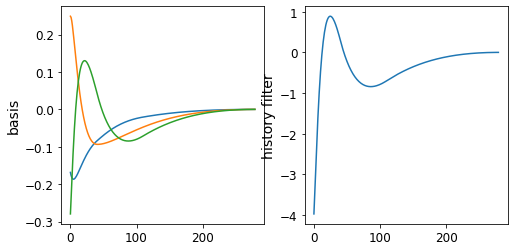

In [2]:
from examples_utils import PALETTE, plot_filter, set_style
from kernel.base import Kernel

set_style()


# Define history filter using a basis of raised cosines
dt = 1
n, last_peak = 3, 40
hist_filter_true = Kernel.orthogonalized_raised_cosines(dt, last_peak, n, 8, a=1, weight=torch.tensor([4., -2., 10.]))

fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)

# Plot basis
t_ker = torch.arange(0, len(hist_filter_true.basis), 1) * dt
ax1.plot(t_ker, hist_filter_true.basis)
ax1.set_ylabel('basis')

# Plot history filter
plot_filter(ax=ax2, filter=hist_filter_true)
ax2.set_ylabel('history filter');

## Define GLM using history kernel and generate samples

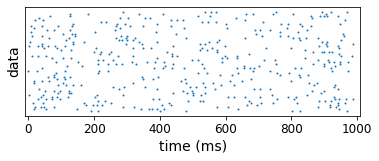

In [3]:
from mmdglm.glm.base import GLM
from mmdglm.metrics import negative_log_likelihood_pp
from mmdglm.utils import plot_spiketrain


# Define number of samples and time points
nsamples = 50
t = torch.arange(0, 1000, 1)

# Define GLM and generate samples
glm_true = GLM(bias=-4.5, hist_kernel=hist_filter_true)
_, mask_spikes = glm_true.sample(t, shape=(nsamples, ))

# Compute total number of spikes and negative log-likelihood of the data assynubg Poisson process
n_spk = torch.sum(mask_spikes).item()
nll_pois_proc_train = negative_log_likelihood_pp(mask_spikes)

# Plot samples
ax = plot_spiketrain(t, mask_spikes, label='data')

## Fit new GLM to the generated data using maximum likelihood (ML-GLM)

In [4]:
from torch.optim import Adam


# Define GLM
bias0 = -6
hist_filter0 = Kernel(basis=hist_filter_true.basis)
mlglm = GLM(bias=bias0, hist_kernel=hist_filter0.clone())

# Define optimization parameters and fit
num_epochs = 200
optim = Adam(mlglm.parameters(), lr=1e-1)
nll_ml, metrics_ml = mlglm.fit(t, mask_spikes, num_epochs=num_epochs, optim=optim, verbose=True)

# Compute negative log-likelihood per spike relative to Poisson process
iterations_ml = torch.arange(1, num_epochs + 1, 1)
nll_ml = torch.tensor(nll_ml)
nll_normed_ml = (nll_ml - nll_pois_proc_train) / math.log(2) / n_spk

 epoch 199 of 200 || loss 2336.4082

## Fit new GLM to the generated data by minimizing the Maximum Mean Discrepancy (MMD)

In [8]:
from examples_utils import compute_mean_mmd
from mmdglm.glm.mmd import MMDGLM
from mmdglm.metrics import negative_log_likelihood, mmd_loss


# Define Schoenberg kernel using cumulative spike trains
def ker_schoenberg(t, mask_spikes1, mask_spikes2, sd2=1e6):
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    diff_cum = torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0)
    gramian = torch.exp(-diff_cum / sd2)
    return gramian


# Function to monitor log-likelihood during optimization (log-likelihood is not being optimized)
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr, **kwargs):
    log_lam = model.log_conditional_intensity(t, mask_spikes)
    nll = negative_log_likelihood(dt, mask_spikes, log_lam)
    return dict(nll=nll.item())

# Define MMD-GLM
mmdglm = MMDGLM(bias=bias0, hist_kernel=hist_filter0.clone())

# Define optimization parameters and fit
n_batch_fr = 200  # Number of samples used to compute MMD at each optimization step
kernel_kwargs = dict(sd2=5e2)  # Scale parameter of the Schoenberg kernel
num_epochs= 200
optim = Adam(mmdglm.parameters(), lr=7e-2, betas=(0, 0))
loss_mmd, nll_train, metrics_mmd = mmdglm.fit(t, mask_spikes, kernel=ker_schoenberg, n_batch_fr=n_batch_fr, 
                                              kernel_kwargs=kernel_kwargs, num_epochs=num_epochs, optim=optim, 
                                              metrics=fun_metrics_mmd, verbose=True)

# Compute negative log-likelihood per spike relative to Poisson process
iterations_mmd = torch.arange(1, num_epochs + 1, 1)
nll_normed_mmd = (torch.tensor(metrics_mmd['nll']) - nll_pois_proc_train) / math.log(2) / n_spk

# Generate samples from MMD-GLM
log_lam_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, shape=(nsamples,))

# Compute MMD for samples generated from ML-GLM
mean_mmd_ml, se_mmd_ml = compute_mean_mmd(mlglm, t, mask_spikes, kernel=ker_schoenberg, n_batch_fr=n_batch_fr)

 epoch 199 of 200 loss -0.0471546654

## Plot

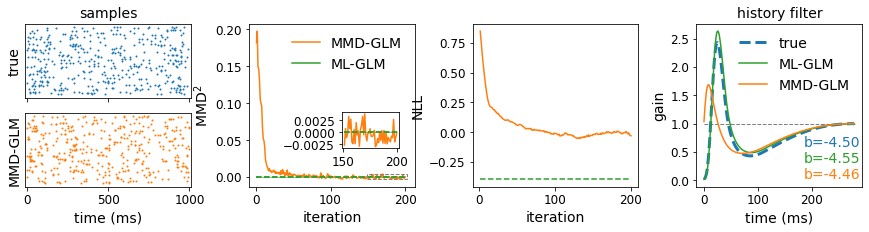

In [9]:
from examples_utils import fig2_layout, plot_filter_bias, plot_mmd


fig, (axd, axmmd_samples, axmmd, axmmd_ins, axnll, axhist) = fig2_layout()

plot_spiketrain(t, mask_spikes, ax=axd, color=PALETTE['data'])
plot_spiketrain(t, mask_spikes_fr_mmd, ax=axmmd_samples, color=PALETTE['mmd-glm'])

plot_mmd(axmmd, iterations_mmd, metrics_mmd['mmd'], mean_mmd_ml, se_mmd_ml)
plot_mmd(axmmd_ins, iterations_mmd, metrics_mmd['mmd'], mean_mmd_ml, se_mmd_ml, first_iteration=num_epochs - 50)
axmmd.indicate_inset_zoom(axmmd_ins, lw=1, alpha=1, linestyle='--')
axmmd.legend(frameon=False)

axnll.plot([1, num_epochs], [nll_normed_ml[-1], nll_normed_ml[-1]], '--', label='ML-GLM', color=PALETTE['ml-glm'])
axnll.plot(iterations_mmd, nll_normed_mmd, label='MMD-GLM', color=PALETTE['mmd-glm'])

plot_filter_bias(axhist, glm_true, gain=True, lw=3, bias_offset=0, linestyle='--', label='true', color=PALETTE['data'])
plot_filter_bias(axhist, mlglm, gain=True, bias_offset=1, label='ML-GLM', color=PALETTE['ml-glm'])
plot_filter_bias(axhist, mmdglm, gain=True, bias_offset=2, label='MMD-GLM', color=PALETTE['mmd-glm'])
axhist.legend(frameon=False)